In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.lite as tflite
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalsePositives, FalseNegatives
from tensorflow.keras.optimizers.legacy import Adam # remove .legacy for OS != MacOS
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow_model_optimization.quantization.keras import quantize_model
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import tqdm
import keras_tuner as kt

print(f'Tensorflow v{tf.__version__}')

Tensorflow v2.12.0


In [2]:
EPOCHS = 30
BATCH_SIZE = 128

In [3]:
train_dataset = np.load('train.npz')
val_dataset = np.load('val.npz')
test_dataset = np.load('test.npz')

In [4]:
train_x = train_dataset['x']
train_y = train_dataset['y']

val_x = val_dataset['x']
val_y = val_dataset['y']

test_x = test_dataset['x']
test_y = test_dataset['y']

Training set: 337021 (99, 65, 1)
Validation set: 112341 (99, 65, 1)
Test set: 112341 (99, 65, 1)


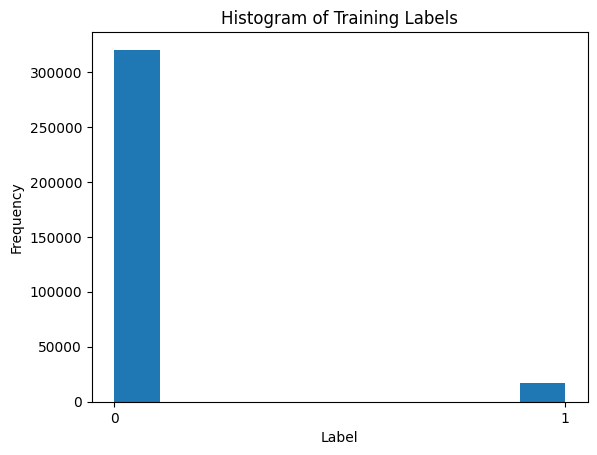

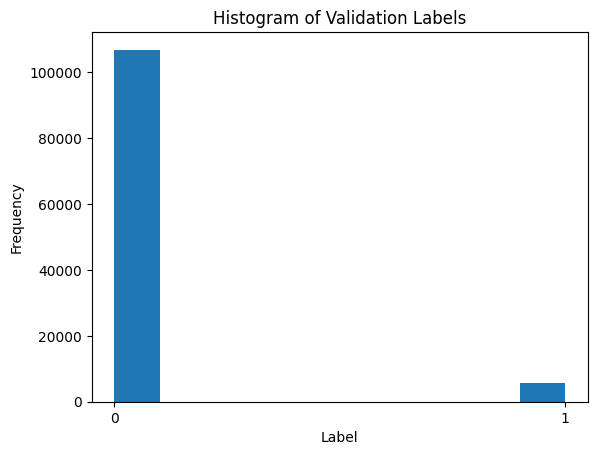

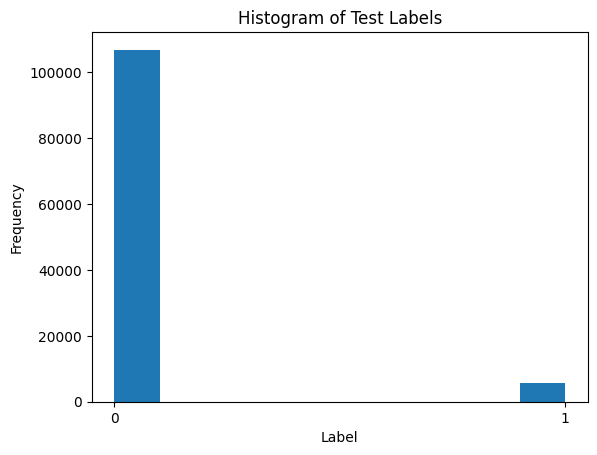

In [5]:
def draw_histogram(Y, name=''):
    plt.hist(Y)
    plt.title(f'Histogram of {name} Labels')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks([0, 1])
    plt.show()

print(f'Training set: {len(train_x)} {train_x[0].shape}')
print(f'Validation set: {len(val_x)} {val_x[0].shape}')
print(f'Test set: {len(test_x)} {test_x[0].shape}')

draw_histogram(train_y, 'Training')
draw_histogram(val_y, 'Validation')
draw_histogram(test_y, 'Test')

In [6]:
train_ds = Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(len(train_x) // 2)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = Dataset.from_tensor_slices((val_x, val_y))
val_ds = val_ds.batch(BATCH_SIZE // 2)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(AUTOTUNE)

test_ds = Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.batch(BATCH_SIZE // 2)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(AUTOTUNE)

Metal device set to: Apple M1


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
QUANTIZATION = True
HYPERTUNING = False

INPUT_SHAPE = train_x[0].shape

MAX_MODEL_SIZE = 150 * 1024

DEFAULT_MODEL = [[16, 5, 4], [32, 5, 4], 64]

earlystop = EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
def build_model(layer_1, layer_2, dense_units):
    model = Sequential(
        name='wake_word',
        layers=[
            Conv2D(
                filters=layer_1[0],
                kernel_size=layer_1[1],
                activation='relu',
                padding='same',
                input_shape=INPUT_SHAPE,
                name='conv2d_1'
            ),
            MaxPooling2D(
                pool_size=layer_1[2],
                padding='same',
                name='pool2d_1'
            ),
            Dropout(
                rate=0.1,
                name='dropout_1'
            ),
            Conv2D(
                filters=layer_2[0],
                kernel_size=layer_2[1],
                activation='relu',
                padding='same',
                name='conv2d_2'
            ),
            MaxPooling2D(
                pool_size=layer_2[2],
                padding='same',
                name='pool2d_2'
            ),
            Dropout(
                rate=0.1,
                name='dropout_2'
            ),
            Flatten(),
            Dense(
                units=dense_units,
                activation='relu',
                name='dense_1'
            ),
            Dropout(
                rate=0.1,
                name='dropout_3'
            ),
            Dense(
                units=1,
                activation='sigmoid',
                name='output'
            )
        ]
    )
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(),
            Precision(),
            Recall(),
            FalsePositives(),
            FalseNegatives()
        ]
    )
    
    return model

In [ ]:
def model_builder(hp):
    conv_filters_1 = hp.Int(
        name='conv_filters_1',
        min_value=16,
        max_value=64,
        step=2,
        sampling='log'
    )
    conv_kernel_1 = hp.Choice(
        name='conv_kernel_1',
        values=[3, 4, 5]
    )
    pooling_1 = hp.Choice(
        name='pooling_1',
        values=[3, 4, 5]
    )
    conv_filters_2 = hp.Int(
        name='conv_filters_2',
        min_value=16,
        max_value=64,
        step=2,
        sampling='log'
    )
    conv_kernel_2 = hp.Choice(
        name='conv_kernel_2',
        values=[3, 4, 5]
    )
    pooling_2 = hp.Choice(
        name='pooling_2',
        values=[3, 4, 5]
    )
    dense_units = hp.Int(
        name='dense_units',
        min_value=16,
        max_value=128,
        step=2,
        sampling='log'
    )
    
    return build_model(
        [conv_filters_1, conv_kernel_1, pooling_1],
        [conv_filters_2, conv_kernel_2, pooling_2],
        dense_units
    )

In [ ]:
if HYPERTUNING:
    tuner = kt.Hyperband(
        model_builder,
        objective='val_binary_accuracy',
        max_epochs=EPOCHS * 2,
        directory='tuner',
        project_name='wake_word',
        overwrite=True,
        max_model_size=MAX_MODEL_SIZE,
        max_consecutive_failed_trials=8
    )
    tuner.search_space_summary()

In [ ]:
if HYPERTUNING:
    tuner.search(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[earlystop], verbose=2)
    tuner.results_summary()
    # first round -> 34 models
    # second round -> 17 + 6 new models (23 total)
    # third round -> 8 models ??

In [ ]:
if HYPERTUNING:
    model = tuner.get_best_models(num_models=1)[0]
else:
    model = build_model(*DEFAULT_MODEL)

In [ ]:
model.summary()

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop]
#     verbose=2
)

In [ ]:
model.trainable = False
model.evaluate(test_ds)

In [ ]:
def get_optimal_threshold(m):
    scores = m.predict(test_x)
    precision, recall, thresholds = precision_recall_curve(test_y, scores)

    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall trade-off')
    plt.legend(loc='lower left')
    plt.show()

    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [ ]:
THRESHOLD = get_optimal_threshold(model)
print(f'Optimal threshold for model is: {THRESHOLD}')

In [ ]:
if QUANTIZATION:
    model.trainable = True
    q_aware_model = quantize_model(model)

    q_aware_model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(),
            Precision(),
            Recall(),
            FalsePositives(),
            FalseNegatives()
        ]
    )

    q_aware_model.summary()

    tf.keras.utils.plot_model(
        q_aware_model,
        to_file='q_aware_model.png',
        show_shapes=True,
        show_layer_activations=True,
        show_trainable=True
    )

In [ ]:
if QUANTIZATION:
    q_history = q_aware_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=1,
        verbose=2
    )

In [ ]:
if QUANTIZATION:
    q_aware_model.trainable = False
    q_aware_model.evaluate(test_ds)

In [ ]:
if QUANTIZATION:
    THRESHOLD = get_optimal_threshold(q_aware_model)
    print(f'Optimal threshold for quantization aware model is: {THRESHOLD}')

In [ ]:
if QUANTIZATION:
    model_to_convert = q_aware_model
else:
    model_to_convert = model

In [ ]:
# def representative_dataset_gen():
#     for data in test_x:
#         yield [np.expand_dims(data, 0)]
# c.target_spec.supported_ops = [tflite.OpsSet.TFLITE_BUILTINS_INT8]
# c.representative_dataset = representative_dataset_gen

c = tflite.TFLiteConverter.from_keras_model(model_to_convert)
c.optimizations = [tflite.Optimize.DEFAULT]
tflite_model = c.convert()

open('model.tflite', 'wb').write(tflite_model)

In [ ]:
tflite.experimental.Analyzer.analyze(model_content=tflite_model)

In [ ]:
interpreter = tflite.Interpreter(model_path=str('model.tflite'))
interpreter.allocate_tensors()

all_data_x = np.concatenate((train_x, val_x, test_x))
all_data_y = np.concatenate((train_y, val_y, test_y))

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [ ]:
score = 0
no_samples = 10000
indexes = np.random.randint(0, all_data_x.shape[0], size=no_samples)
progress_bar = tqdm(total=no_samples, desc='Testing samples')

for i in indexes:
    data = tf.expand_dims(all_data_x[i], 0)
    label = all_data_y[i]
    
    interpreter.set_tensor(input_details['index'], data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details['index'])[0][0]
    
    wake_word_detected = 1.0 if output > THRESHOLD else 0.0
    if label == wake_word_detected:
        score += 1
    else:
        print(label, output)
        
    progress_bar.update()

print(score / no_samples)